In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import statistics as sts
import lmfit
from lmfit import Model
from scipy.stats import sem

#Functions

# Linear Fit
def line(x, m, b):
    return x * m + b
gmodel = Model(line)
param = gmodel.make_params()


In [31]:

# Questions
plot = input('Plot?')
save = input('Save?')
f = input('Include linear fit?')
table = input('Make table?')

# Variables
split = 'LSB_07'
metals = {'0G_13': 'Pt',
          '0G_14' : 'Al',
          '0G_15' : 'Mo',
          '0G_16' : 'Cr',
        }
measurements = {'Pt' : {},
                'Al' : {},
                'Mo' : {},
                'Cr' : {}
                }

# Folder where the files are
data_path = os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split, 'LCR')
dict = {}
r_dict = {}
row_names = []
for i in os.listdir(data_path):
    files = os.listdir(os.path.join(data_path, i))
    for j in files:
        row_names.append(metals[i] + ' ' + j[:-4])
        data = pd.read_csv(os.path.join(data_path, i, j))
        dict[j] = (data['DC'], data['Idc'], data['Vds'])
        result = gmodel.fit(dict[j][1], param, m = 1, b = 1, x = dict[j][2])
        resistance = np.round(1 / result.values['m'], decimals = 2)
        r_square = 1 - result.residual.var() / np.var(dict[j][1])
        r_dict[metals[i] + ' ' + j[:-4]] = (float(resistance))
        measurements[metals[i]][j[:-4]] = (dict[j], resistance, r_square)
        
        if plot == 'y':

            fig, ax = plt.subplots(facecolor = 'white')
            ax.set_title(metals[i] + ' ' + i + ' ' + j[:-4])
            ax.set_xlabel('Potential Vds (V)')
            ax.set_ylabel('Current Ids (A)')
            ax.scatter(dict[j][2], dict[j][1], s = 1, label = 'Measurement')
            ax.legend(markerscale = 5)

            if save == 'y':
                plt.savefig(os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split,
                            'Plots', i, metals[i] + ' ' + j[:-4]) + '.png', facecolor = 'white',  bbox_inches='tight')

            if f == 'y':

                fig, ax = plt.subplots(facecolor = 'white')
                ax.set_title(metals[i] + ' ' + i + ' ' + j[:-4])
                ax.set_xlabel('Potential Vds (V)')
                ax.set_ylabel('Current Ids (A)')
                ax.scatter(dict[j][2], dict[j][1], s = 1, label = 'Measurement')
                ax.plot(dict[j][2], result.best_fit, alpha = 0.5, label = 'Linear Fit')
                ax.plot([],[], ' ', label = '{:.2f}'.format(resistance) + ' $\Omega$')
                ax.plot([],[], ' ', label = 'r$^2$ = ' + '{:.5f}'.format(r_square))
                ax.legend(markerscale = 5)

                if save == 'y':
                    plt.savefig(os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split,
                            'Plots', i, 'Fit_' + metals[i] + ' ' + j[:-4]) + '.png', facecolor = 'white',  bbox_inches='tight')
# resistance_data = pd.DataFrame(list(r_dict.values()), columns = ['Resistance (Ω)'], index = r_dict.keys())
# if table == 'y':
#     fig, ax = plt.subplots()
#     ax.axis('off')
#     t = ax.table(cellText=resistance_data.items, cellLoc='center', colLabels= ['Sample', 'Resistance ($\Omega$)'])
#     if save == 'y':
#         plt.savefig(os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split,
#                             'Plots', i, 'Table_Resistance ') + '.png', facecolor = 'white',  bbox_inches='tight')


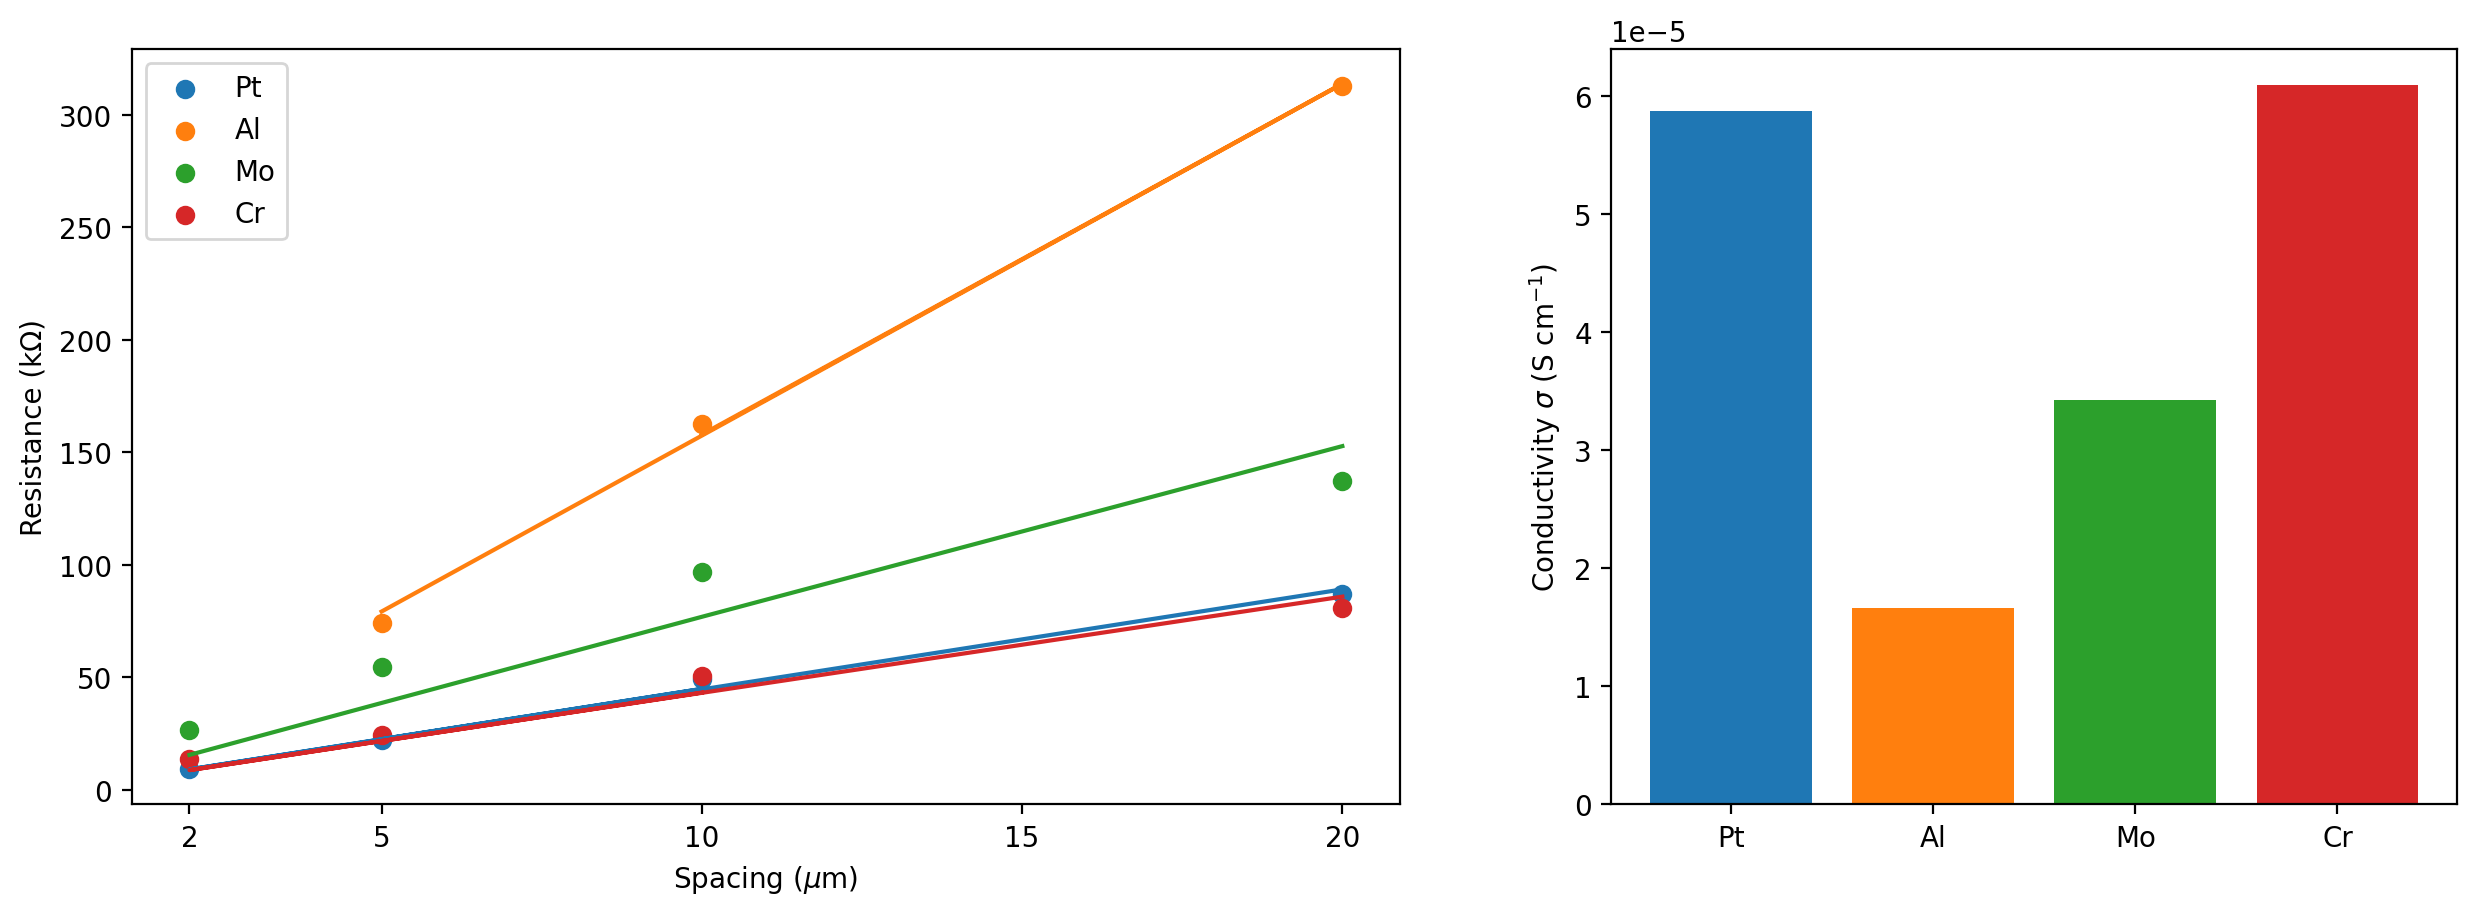

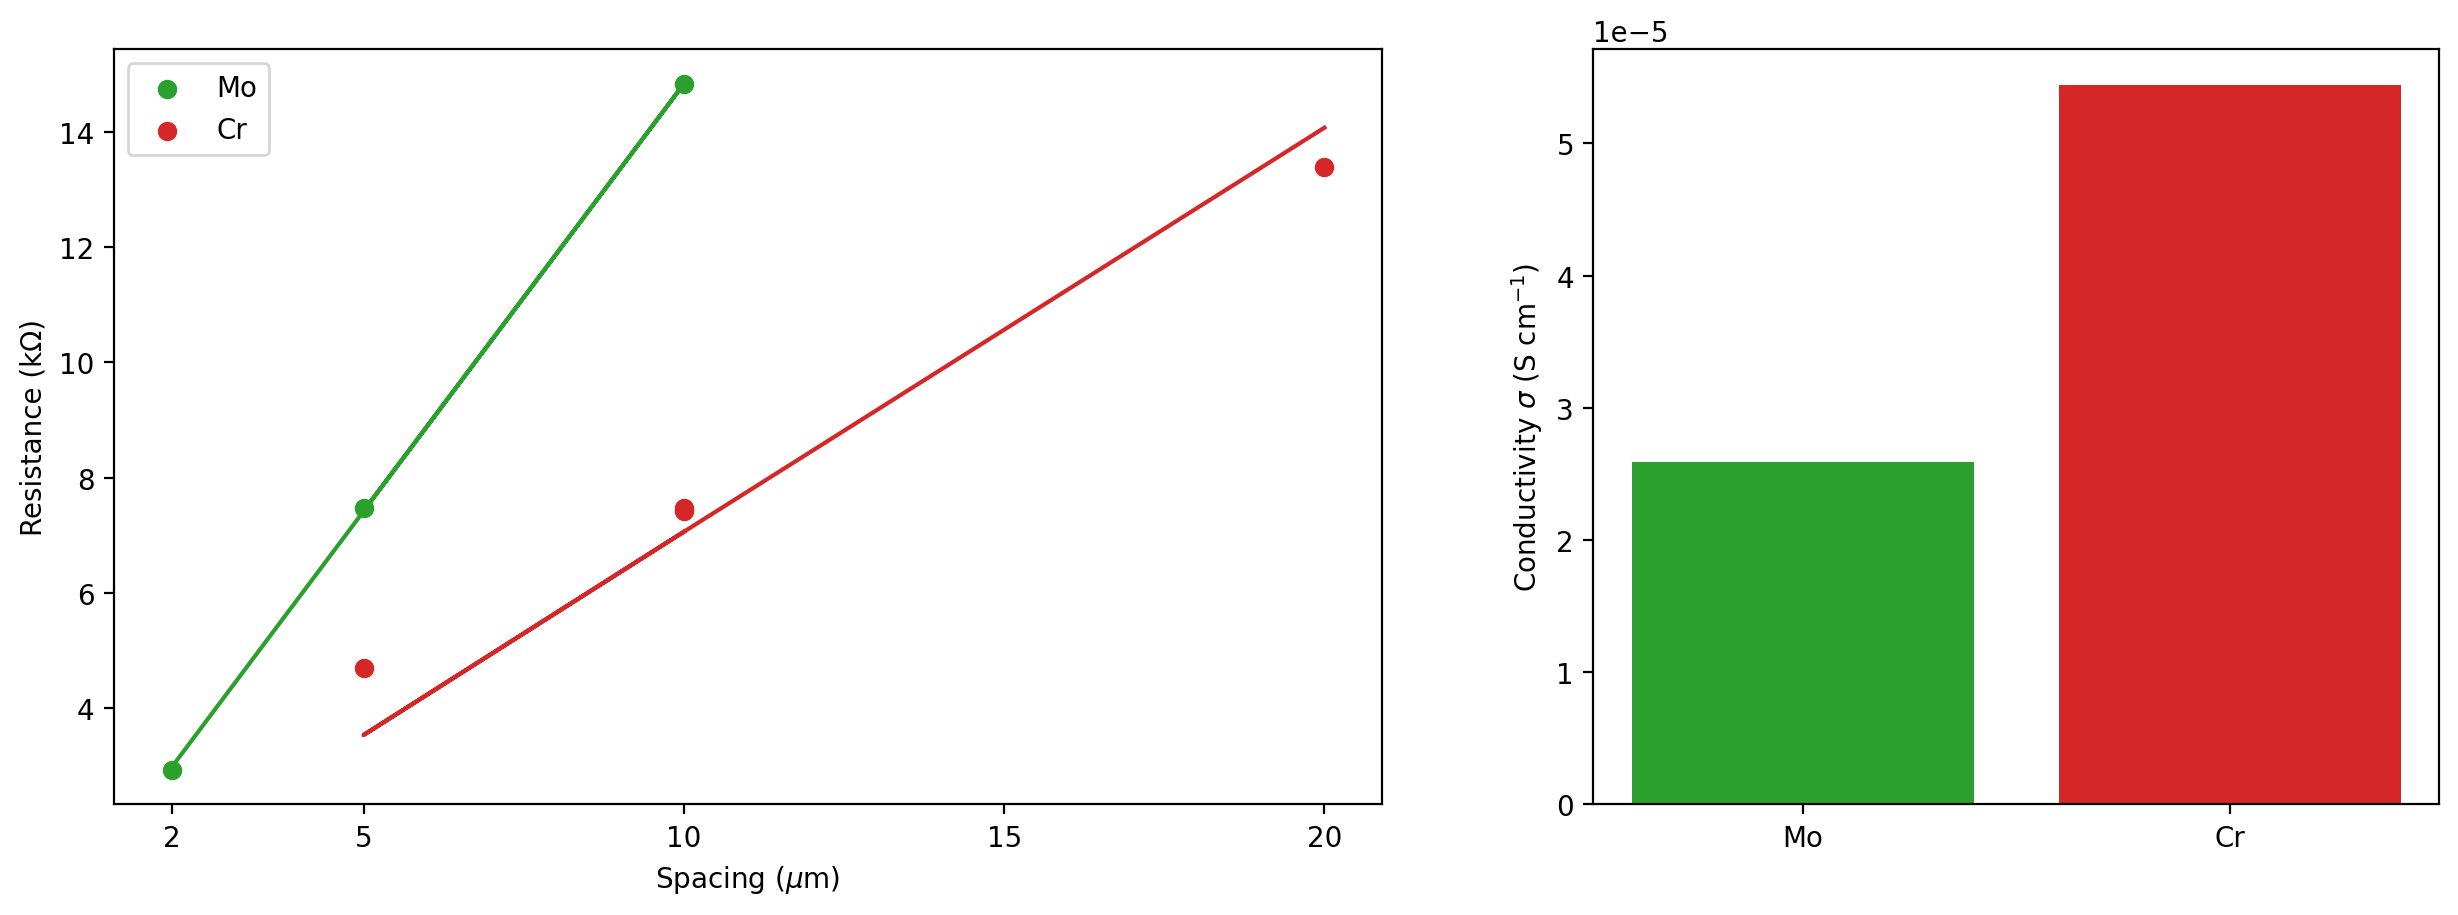

In [42]:
# Resistance as a function of area of test structures
def idea_res(s, sigma, N, W, L, d):
    #return s / (sigma * 0.2e-4 * (60 * 5e-4 + (60 - 1) * (2 * s + 3200e-4))) # Check units \sigma = S cm-1
    return s / (sigma * d * (N * W + (N - 1) * (2 * s + L)))

gmodel2 = Model(idea_res)
param2 = gmodel2.make_params(sigma = 5e-9, N = 60, W = 5e-4, L = 3200e-4, d = 0.2e-4)
param2['L'].set(vary = False)
param2['W'].set(vary = False)
param2['N'].set(vary = False)
param2['d'].set(vary = False)


#Plot
plot_path = os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split, 'Plots')
colors = {'Pt' : 'tab:blue',
          'Al' : 'tab:orange',
          'Mo' : 'tab:green',
          'Cr' : 'tab:red'
        }

fig, ax = plt.subplots(dpi = 200,figsize = (15, 5), facecolor = 'white', ncols = 2, gridspec_kw={'width_ratios': [3, 2]})
ax[0].set_xticks(np.array([2, 5, 10, 15, 20]))
ax[0].set_ylabel('Resistance (kΩ)')
ax[0].set_xlabel('Spacing ($\mu$m)')
ax[1].set_ylabel('Conductivity $\sigma$ (S cm$^{-1}$)')

q = {} #filter P02, P03 and P04

for i in measurements.keys():
    q[i] = []
    for j in measurements[i].keys():
        r_kohm = measurements[i][j][1]
        if 'P01' in j[3:]:
            q[i].append((2e-4, r_kohm))
        elif 'P02' in j[3:]:
            q[i].append((5e-4, r_kohm))
        elif 'P03' in j[3:]:
            q[i].append((10e-4, r_kohm))
        elif 'P04' in j[3:]:
            q[i].append((20e-4, r_kohm))
            
for i in q.keys():
    x, y = zip(*q[i])
    x = np.array(x)
    y = np.array(y)
    ax[0].scatter(x * 1e4, y / 1000, label = i, c = colors[i])
    fit = gmodel2.fit(y, param2, s = x)
    ax[0].plot(x * 1e4, fit.best_fit / 1000, color = colors[i])
    dely = fit.eval_uncertainty()
    #ax[0].fill_between(x * 1e4, (fit.best_fit - dely) / 1000, (fit.best_fit + dely) / 1000, color = colors[i], alpha = 0.2)
    ax[1].bar(i, fit.values['sigma'], color = colors[i])
    
ax[0].legend()
#plt.savefig(os.path.join(plot_path, 'Conductivity_1234') + '.png', facecolor = 'white',  bbox_inches='tight')

# Change of parameters for fit
param2['L'].set(value = 5000e-4)
param2['N'].set(value = 260)

fig, ax = plt.subplots(dpi = 200, figsize = (15, 5), facecolor = 'white', ncols = 2, gridspec_kw={'width_ratios': [3, 2]})
ax[0].set_xticks(np.array([2, 5, 10, 15, 20]))
ax[0].set_ylabel('Resistance (kΩ)')
ax[0].set_xlabel('Spacing ($\mu$m)')
ax[1].set_ylabel('Conductivity $\sigma$ (S cm$^{-1}$)')
q = {} #filter P05, P06, P07 and P08

for i in measurements.keys():
    q[i] = []
    for j in measurements[i].keys():
        r_kohm = measurements[i][j][1] # / 1000
        if 'P05' in j[3:]:
            q[i].append((2e-4, r_kohm))
        elif 'P06' in j[3:]:
            q[i].append((5e-4, r_kohm))
        elif 'P07' in j[3:]:
            q[i].append((10e-4, r_kohm))
        elif 'P08' in j[3:]:
            q[i].append((20e-4, r_kohm))

for i in q.keys():
    if len(q[i]) > 0:
        x, y = zip(*q[i])
        x = np.array(x)
        y = np.array(y)
        ax[0].scatter(x * 1e4, y / 1000, label = i, c = colors[i])
        fit = gmodel2.fit(y, param2, s = x)
        ax[0].plot(x* 1e4 , fit.best_fit / 1000, color = colors[i])
        dely = fit.eval_uncertainty()
        #ax[0].fill_between(x * 1e4, (fit.best_fit - dely) / 1000, (fit.best_fit + dely) / 1000, color = colors[i], alpha = 0.2)
        ax[1].bar(i, fit.values['sigma'], color = colors[i])
    
ax[0].legend()
# plt.savefig(os.path.join(plot_path, 'Conductivity_5678') + '.png', facecolor = 'white',  bbox_inches='tight')

